<a href="https://colab.research.google.com/github/apschlissel/w266-final-project/blob/main/T5_classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T5 Classification - Reddit Data

Contains:
* T5 model creation
* Training on different n-sizes
* Many different dataset configurations

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.5 MB 30.9 MB/s 
     |████████████████████████████████| 77 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 895 kB 42.9 MB/s 


In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 249 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 43.1 MB/s 
     |████████████████████████████████| 1.8 MB 34.7 MB/s 
     |████████████████████████████████| 325 kB 65.6 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 10.1 MB 35.0 MB/s 
     |████████████████████████████████| 181 kB 46.3 MB/s 
     |████████████████████████████████| 144 kB 61.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 136 kB 51.3 MB/s 
     |████████████████████████████████| 1.1 MB 25.0 MB/s 
     |████████████████████████████████| 212 kB 53.8 MB/s 
     |████████████████████████████████| 127 kB 58.2 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 55.6 MB/s 
     |████████████████████████████████| 271 kB 60.0 MB/s 
     |████████████████████████████████| 111 kB 61.0 MB/s 
     |██████████████

In [ ]:
from __future__ import print_function
import ipywidgets as widgets
from transformers import pipeline
from simpletransformers.t5 import T5Model, T5Args
from transformers.data.metrics.squad_metrics import compute_exact, compute_f1
import pandas as pd
import logging
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
import json
import re
import random
import math
from statistics import mean
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
# Pull reddit data from reddit api
import requests
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_rows', 100)

## Load Reddit Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#dataset configurations

df_similar_sub_5000 = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/similar_subreddits_5000_df.csv')

df_similar_sub_1000 = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/similar_subreddits_1000_df.csv')

df_similar_sub_500 = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/similar_subreddits_500_df.csv')

df_random_sub_5000 = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/random_subreddits_5000_df.csv')

df_random_sub_1000 = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/random_subreddits_1000_df.csv')

df_random_sub_500 = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/random_subreddits_500_df.csv')

df_handpicked_sub_5000 = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/handpicked_subreddits_5000_df.csv')

df_handpicked_sub_1000 = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/handpicked_subreddits_1000_df.csv')

df_handpicked_sub_500 = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/handpicked_subreddits_500_df.csv')



In [ ]:
#split into train/val/test

def train_val_test_split(df):

  train, val = train_test_split(df.index.values, 
                                test_size=0.20, 
                                random_state=42, 
                                stratify=df.subreddit.values)
  
  val, test = train_test_split(val, test_size=0.5, random_state=42)

  df_train = df[df.index.isin(train)]
  df_val = df[df.index.isin(val)]
  df_test = df[df.index.isin(test)]

  return df_train, df_val, df_test



In [ ]:
df_similar_sub_5000_train, df_similar_sub_5000_val, df_similar_sub_5000_test = train_val_test_split(df_similar_sub_5000)
df_similar_sub_1000_train, df_similar_sub_1000_val, df_similar_sub_1000_test = train_val_test_split(df_similar_sub_1000)
df_similar_sub_500_train, df_similar_sub_500_val, df_similar_sub_500_test = train_val_test_split(df_similar_sub_500)

df_random_sub_5000_train, df_random_sub_5000_val, df_random_sub_5000_test = train_val_test_split(df_random_sub_5000)
df_random_sub_1000_train, df_random_sub_1000_val, df_random_sub_1000_test = train_val_test_split(df_random_sub_1000)
df_random_sub_500_train, df_random_sub_500_val, df_random_sub_500_test = train_val_test_split(df_random_sub_500)

df_handpicked_sub_5000_train, df_handpicked_sub_5000_val, df_handpicked_sub_5000_test = train_val_test_split(df_handpicked_sub_5000)
df_handpicked_sub_1000_train, df_handpicked_sub_1000_val, df_handpicked_sub_1000_test = train_val_test_split(df_handpicked_sub_1000)
df_handpicked_sub_500_train, df_handpicked_sub_500_val, df_handpicked_sub_500_test = train_val_test_split(df_handpicked_sub_500)

## Load Slang Data
Data are a direct translation of slang to their non-slang synonym

In [ ]:
slang = pd.read_csv('gdrive/MyDrive/grad_school/w266/final_project/slang_dictionary_final.csv')
slang.head(20)

,Slang Term,Meaning
0,@@-o,tattletale
1,@teotd,at the end of the day
2,^5,high five
3,0773h,hello
4,10m,10 minutes
5,10q,thank you
6,10x,10 times
7,1337,leet speak
8,143,i love you
9,1up,extra life


In [ ]:
slangit_dict = slang.set_index('Slang Term').to_dict()
slangit_dict = slangit_dict['Meaning']

In [ ]:
keys_values = slangit_dict.items()
slangit_dict = {str(key): str(value) for key, value in keys_values}

In [ ]:
def slang_lookup(text, dictionary):
    
    #try to make any case
    #try to make it only words with spaces
    text = text.lower()
    pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in slangit_dict.keys()) + r')(?!\w)')
    result = pattern.sub(lambda x: dictionary[x.group()], text)

    return result

In [ ]:
my_text = 'I watched the UNC game at a bar b/c YOLO, FTW'

print(slang_lookup(my_text, slangit_dict))

i watched the unc game at a bar because you only live once, for the win


In [ ]:
df_similar_sub_5000_train.head()

,subreddit,text
0,gaming,'Four Friends' by SpaceCaptSteve
1,gaming,Your Welcome
2,gaming,Mum surprised me with this for my birthday.
3,gaming,ASUS Announces GeForce GTX 970 Turbo Graphics Card
4,gaming,"Read and give the reviews and rating on app games, How's your experience"


In [ ]:
#apply deslanging to all the train sets

df_similar_sub_5000_train['text_deslanged'] = df_similar_sub_5000_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_similar_sub_1000_train['text_deslanged'] = df_similar_sub_1000_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_similar_sub_500_train['text_deslanged'] = df_similar_sub_500_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))

df_random_sub_5000_train['text_deslanged'] = df_random_sub_5000_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_random_sub_1000_train['text_deslanged'] = df_random_sub_1000_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_random_sub_500_train['text_deslanged'] = df_random_sub_500_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))

df_handpicked_sub_5000_train['text_deslanged'] = df_handpicked_sub_5000_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_handpicked_sub_1000_train['text_deslanged'] = df_handpicked_sub_1000_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_handpicked_sub_500_train['text_deslanged'] = df_handpicked_sub_500_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
#do same thing to val
df_similar_sub_5000_val['text_deslanged'] = df_similar_sub_5000_val['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_similar_sub_1000_val['text_deslanged'] = df_similar_sub_1000_val['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_similar_sub_500_val['text_deslanged'] = df_similar_sub_500_val['text'].apply(lambda x: slang_lookup(x, slangit_dict))

df_random_sub_5000_val['text_deslanged'] = df_random_sub_5000_val['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_random_sub_1000_val['text_deslanged'] = df_random_sub_1000_val['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_random_sub_500_val['text_deslanged'] = df_random_sub_500_val['text'].apply(lambda x: slang_lookup(x, slangit_dict))

df_handpicked_sub_5000_val['text_deslanged'] = df_handpicked_sub_5000_val['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_handpicked_sub_1000_val['text_deslanged'] = df_handpicked_sub_1000_val['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_handpicked_sub_500_val['text_deslanged'] = df_handpicked_sub_500_val['text'].apply(lambda x: slang_lookup(x, slangit_dict))

In [ ]:
#do same thing to test
df_similar_sub_5000_test['text_deslanged'] = df_similar_sub_5000_test['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_similar_sub_1000_test['text_deslanged'] = df_similar_sub_1000_test['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_similar_sub_500_test['text_deslanged'] = df_similar_sub_500_test['text'].apply(lambda x: slang_lookup(x, slangit_dict))

df_random_sub_5000_test['text_deslanged'] = df_random_sub_5000_test['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_random_sub_1000_test['text_deslanged'] = df_random_sub_1000_test['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_random_sub_500_test['text_deslanged'] = df_random_sub_500_test['text'].apply(lambda x: slang_lookup(x, slangit_dict))

df_handpicked_sub_5000_test['text_deslanged'] = df_handpicked_sub_5000_test['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_handpicked_sub_1000_test['text_deslanged'] = df_handpicked_sub_1000_test['text'].apply(lambda x: slang_lookup(x, slangit_dict))
df_handpicked_sub_500_test['text_deslanged'] = df_handpicked_sub_500_test['text'].apply(lambda x: slang_lookup(x, slangit_dict))

In [ ]:
df_random_sub_5000_val.head()

,subreddit,text,text_deslanged
4,Bitcoin,"Andreas Antonopoulos at DEC-TECH Toronto ""Five Stages of Grief"" March 2015","andreas antonopoulos at dec-technology toronto ""five stages of grief"" march 2015"
5,Bitcoin,Fess up. Make a new account if need be. Would be great if some big players chimed in.,fess up. make a new account intermittent fasting need be. would be great intermittent fasting some big players chimed in.
9,Bitcoin,"**Welcome to the /r/Bitcoin daily discussion thread!**\n\n---\n\n**Thread topics include, but are not limited to:**\n\n* General discussion of current events related to Bitcoin\n* Questions, thoughts and observations that do not warrant a separate post\n* Cool stuff you bought with bitcoin recently\n\n**Thread Guidelines**\n\n* **Be excellent to each other.**\n","**welcome to the /are/bitcoin daily discussion thread!**\n\n---\n\n**thread topics include, but are not limited to:**\n\n* general discussion of current events related to bitcoin\n* questions, thoughts allow natural death observations that do not warrant a separate post\n* cool stuff you bought with bitcoin recently\n\n**thread guidelines**\n\n* **be excellent to each other.**\n"
34,Bitcoin,"$670 000 VC Investment In Licensed Bitcoin Gaming Platform Betkurus, Now Offering Worlds First Instant Bitcoin-To-Fiat Deposits","$670 000 voice chat investment in licensed bitcoin gaming platform betkurus, now offering worlds first instant bitcoin-to-fiat deposits"
55,Bitcoin,"I like my current cold storage methods, but I was thinking of venturing into the world of multisig to make them even more secure. \n\nAny suggestions on the best place(s) to get started? These are my main questions:\n\n- Can I download a script that will let me generate multisig offline? \n\n- When spending from a multisig address, are all wallets compatible (bitcoin core, electrum, multibit, blockchain.info, etc)? How do you spend from multisig?","i like my current a cryptocurrency wallet not connected to the internet methods, but i wait a second thinking of venturing into the world of multisig to make them even more secure. \n\nany suggestions on the best place(s) to get started? these are my main character questions:\n\n- can i download a script that will leaving early today me generate multisig offline? \n\n- when spending from a multisig address, are all wallets compatible (bitcoin core, electrum, multibit, blockchain.information, etc)? how do you spend from multisig?"


In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

#prep data for t5 - NOT DESLANGED
def prep_data(df, text, label):

  data = df[[text, label]]
  df['prefix'] = 'multilabel classification'
  df = df[['prefix', text, label]]
  df = df.rename(columns={'prefix': 'prefix', text: 'input_text', label: 'target_text'})
  
  return df

#train
df_similar_sub_5000_train_prep = prep_data(df_similar_sub_5000_train, 'text', 'subreddit')
df_similar_sub_1000_train_prep = prep_data(df_similar_sub_1000_train, 'text', 'subreddit')
df_similar_sub_500_train_prep = prep_data(df_similar_sub_500_train, 'text', 'subreddit')

df_random_sub_5000_train_prep = prep_data(df_random_sub_5000_train, 'text', 'subreddit')
df_random_sub_1000_train_prep = prep_data(df_random_sub_1000_train, 'text', 'subreddit')
df_random_sub_500_train_prep = prep_data(df_random_sub_500_train, 'text', 'subreddit')

df_handpicked_sub_5000_train_prep = prep_data(df_handpicked_sub_5000_train, 'text', 'subreddit')
df_handpicked_sub_1000_train_prep = prep_data(df_handpicked_sub_1000_train, 'text', 'subreddit')
df_handpicked_sub_500_train_prep = prep_data(df_handpicked_sub_500_train, 'text', 'subreddit')

#val
df_similar_sub_5000_val_prep = prep_data(df_similar_sub_5000_val, 'text', 'subreddit')
df_similar_sub_1000_val_prep = prep_data(df_similar_sub_1000_val, 'text', 'subreddit')
df_similar_sub_500_val_prep = prep_data(df_similar_sub_500_val, 'text', 'subreddit')

df_random_sub_5000_val_prep = prep_data(df_random_sub_5000_val, 'text', 'subreddit')
df_random_sub_1000_val_prep = prep_data(df_random_sub_1000_val, 'text', 'subreddit')
df_random_sub_500_val_prep = prep_data(df_random_sub_500_val, 'text', 'subreddit')

df_handpicked_sub_5000_val_prep = prep_data(df_handpicked_sub_5000_val, 'text', 'subreddit')
df_handpicked_sub_1000_val_prep = prep_data(df_handpicked_sub_1000_val, 'text', 'subreddit')
df_handpicked_sub_500_val_prep = prep_data(df_handpicked_sub_500_val, 'text', 'subreddit')

#test
df_similar_sub_5000_test_prep = prep_data(df_similar_sub_5000_test, 'text', 'subreddit')
df_similar_sub_1000_test_prep = prep_data(df_similar_sub_1000_test, 'text', 'subreddit')
df_similar_sub_500_test_prep = prep_data(df_similar_sub_500_test, 'text', 'subreddit')

df_random_sub_5000_test_prep = prep_data(df_random_sub_5000_test, 'text', 'subreddit')
df_random_sub_1000_test_prep = prep_data(df_random_sub_1000_test, 'text', 'subreddit')
df_random_sub_500_test_prep = prep_data(df_random_sub_500_test, 'text', 'subreddit')

df_handpicked_sub_5000_test_prep = prep_data(df_handpicked_sub_5000_test, 'text', 'subreddit')
df_handpicked_sub_1000_test_prep = prep_data(df_handpicked_sub_1000_test, 'text', 'subreddit')
df_handpicked_sub_500_test_prep = prep_data(df_handpicked_sub_500_test, 'text', 'subreddit')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [ ]:
#prep data for t5
def prep_data(df, text, label):

  data = df[[text, label]]
  df['prefix'] = 'multilabel classification'
  df = df[['prefix', text, label]]
  df = df.rename(columns={'prefix': 'prefix', text: 'input_text', label: 'target_text'})
  
  return df

In [ ]:
#train
df_similar_sub_5000_train_prep_deslang = prep_data(df_similar_sub_5000_train, 'text_deslanged', 'subreddit')
df_similar_sub_1000_train_prep_deslang = prep_data(df_similar_sub_1000_train, 'text_deslanged', 'subreddit')
df_similar_sub_500_train_prep_deslang = prep_data(df_similar_sub_500_train, 'text_deslanged', 'subreddit')

df_random_sub_5000_train_prep_deslang = prep_data(df_random_sub_5000_train, 'text_deslanged', 'subreddit')
df_random_sub_1000_train_prep_deslang = prep_data(df_random_sub_1000_train, 'text_deslanged', 'subreddit')
df_random_sub_500_train_prep_deslang = prep_data(df_random_sub_500_train, 'text_deslanged', 'subreddit')

df_handpicked_sub_5000_train_prep_deslang = prep_data(df_handpicked_sub_5000_train, 'text_deslanged', 'subreddit')
df_handpicked_sub_1000_train_prep_deslang = prep_data(df_handpicked_sub_1000_train, 'text_deslanged', 'subreddit')
df_handpicked_sub_500_train_prep_deslang = prep_data(df_handpicked_sub_500_train, 'text_deslanged', 'subreddit')

#val
df_similar_sub_5000_val_prep_deslang = prep_data(df_similar_sub_5000_val, 'text_deslanged', 'subreddit')
df_similar_sub_1000_val_prep_deslang = prep_data(df_similar_sub_1000_val, 'text_deslanged', 'subreddit')
df_similar_sub_500_val_prep_deslang = prep_data(df_similar_sub_500_val, 'text_deslanged', 'subreddit')

df_random_sub_5000_val_prep_deslang = prep_data(df_random_sub_5000_val, 'text_deslanged', 'subreddit')
df_random_sub_1000_val_prep_deslang = prep_data(df_random_sub_1000_val, 'text_deslanged', 'subreddit')
df_random_sub_500_val_prep_deslang = prep_data(df_random_sub_500_val, 'text_deslanged', 'subreddit')

df_handpicked_sub_5000_val_prep_deslang = prep_data(df_handpicked_sub_5000_val, 'text_deslanged', 'subreddit')
df_handpicked_sub_1000_val_prep_deslang = prep_data(df_handpicked_sub_1000_val, 'text_deslanged', 'subreddit')
df_handpicked_sub_500_val_prep_deslang = prep_data(df_handpicked_sub_500_val, 'text_deslanged', 'subreddit')

#test
df_similar_sub_5000_test_prep_deslang = prep_data(df_similar_sub_5000_test, 'text_deslanged', 'subreddit')
df_similar_sub_1000_test_prep_deslang = prep_data(df_similar_sub_1000_test, 'text_deslanged', 'subreddit')
df_similar_sub_500_test_prep_deslang = prep_data(df_similar_sub_500_test, 'text_deslanged', 'subreddit')

df_random_sub_5000_test_prep_deslang = prep_data(df_random_sub_5000_test, 'text_deslanged', 'subreddit')
df_random_sub_1000_test_prep_deslang = prep_data(df_random_sub_1000_test, 'text_deslanged', 'subreddit')
df_random_sub_500_test_prep_deslang = prep_data(df_random_sub_500_test, 'text_deslanged', 'subreddit')

df_handpicked_sub_5000_test_prep_deslang = prep_data(df_handpicked_sub_5000_test, 'text_deslanged', 'subreddit')
df_handpicked_sub_1000_test_prep_deslang = prep_data(df_handpicked_sub_1000_test, 'text_deslanged', 'subreddit')
df_handpicked_sub_500_test_prep_deslang = prep_data(df_handpicked_sub_500_test, 'text_deslanged', 'subreddit')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [ ]:
model_args = T5Args()
model_args.num_train_epochs = 1
model_args.no_save = True
model_args.evaluate_generated_text = True
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True
model_args.overwrite_output_dir = True
torch.cuda.memory_summary(device=None, abbreviated=False)
model_args.per_gpu_train_batch_size = 128

model = T5Model("t5", "t5-base", args=model_args, use_cuda=True)


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

In [ ]:
def count_matches(labels, preds):
    print(labels)
    print(preds)
    return sum([1 if label == pred else 0 for label, pred in zip(labels, preds)])

In [ ]:
def f1(truths, preds):
    return mean([compute_f1(truth, pred) for truth, pred in zip(truths, preds)])

In [ ]:
#model.train_model(train_df, eval_data=eval_df, matches=count_matches)
model.train_model(df_similar_sub_500_train_prep, eval_data=df_similar_sub_500_val_prep, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

NameError: ignored

In [ ]:
t5_similar_500_slang = model.eval_model(df_similar_sub_500_test_prep, f1=f1)
print(t5_similar_500_slang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.27359915620763786, 'f1': 0.688}


{'eval_loss': 0.27359915620763786, 'f1': 0.688}


In [ ]:
model.train_model(df_random_sub_500_train_prep, eval_data=df_random_sub_500_val_prep, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.19226897228509188, 'f1': 0.852}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(250,
 {'global_step': [250],
  'eval_loss': [0.19226897228509188],
  'train_loss': [0.4225143790245056],
  'f1': [0.852]})

In [ ]:
t5_random_500_slang = model.eval_model(df_random_sub_500_test_prep, f1=f1)
print(t5_random_500_slang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.1826236853376031, 'f1': 0.872}


{'eval_loss': 0.1826236853376031, 'f1': 0.872}


In [ ]:
model.train_model(df_handpicked_sub_500_train_prep, eval_data=df_handpicked_sub_500_val_prep, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.23965541110374033, 'f1': 0.644}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(250,
 {'global_step': [250],
  'eval_loss': [0.23965541110374033],
  'train_loss': [0.2731221914291382],
  'f1': [0.644]})

In [ ]:
t5_handpicked_500_slang = model.eval_model(df_handpicked_sub_500_test_prep, f1=f1)
print(t5_handpicked_500_slang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.2567822120618075, 'f1': 0.616}


{'eval_loss': 0.2567822120618075, 'f1': 0.616}


In [ ]:
model.train_model(df_similar_sub_1000_train_prep, eval_data=df_similar_sub_1000_val_prep, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1284000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.30730720121590865, 'f1': 0.654}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(500,
 {'global_step': [500],
  'eval_loss': [0.30730720121590865],
  'train_loss': [0.05762629583477974],
  'f1': [0.654]})

In [ ]:
t5_similar_1000_slang = model.eval_model(df_similar_sub_1000_test_prep, f1=f1)
print(t5_similar_1000_slang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.33911291660652276, 'f1': 0.612}


{'eval_loss': 0.33911291660652276, 'f1': 0.612}


In [ ]:
model.train_model(df_random_sub_1000_train_prep, eval_data=df_random_sub_1000_val_prep, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1284000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.31732698535871884, 'f1': 0.766}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(500,
 {'global_step': [500],
  'eval_loss': [0.31732698535871884],
  'train_loss': [0.6890969276428223],
  'f1': [0.766]})

In [ ]:
t5_random_1000_slang = model.eval_model(df_random_sub_1000_test_prep, f1=f1)
print(t5_random_1000_slang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.2891825929520622, 'f1': 0.75}


{'eval_loss': 0.2891825929520622, 'f1': 0.75}


In [ ]:
model.train_model(df_handpicked_sub_1000_train_prep, eval_data=df_handpicked_sub_1000_val_prep, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1284000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.24246613243742596, 'f1': 0.606}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(500,
 {'global_step': [500],
  'eval_loss': [0.24246613243742596],
  'train_loss': [0.25626900792121887],
  'f1': [0.606]})

In [ ]:
t5_handpicked_1000_slang = model.eval_model(df_handpicked_sub_1000_test_prep, f1=f1)
print(t5_handpicked_1000_slang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.23307938087317678, 'f1': 0.644}


{'eval_loss': 0.23307938087317678, 'f1': 0.644}


### Deslanged Text

In [ ]:
model.train_model(df_similar_sub_500_train_prep_deslang, eval_data=df_similar_sub_500_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.3060232256539166, 'f1': 0.688}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(250,
 {'global_step': [250],
  'eval_loss': [0.3060232256539166],
  'train_loss': [0.061171840876340866],
  'f1': [0.688]})

In [ ]:
t5_similar_500_deslang = model.eval_model(df_similar_sub_500_test_prep_deslang, f1=f1)
print(t5_similar_500_deslang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.2895763334527146, 'f1': 0.68}


{'eval_loss': 0.2895763334527146, 'f1': 0.68}


In [ ]:
model.train_model(df_random_sub_500_train_prep_deslang, eval_data=df_random_sub_500_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.10434118536068127, 'f1': 0.936}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(250,
 {'global_step': [250],
  'eval_loss': [0.10434118536068127],
  'train_loss': [0.029462961480021477],
  'f1': [0.936]})

In [ ]:
t5_random_500_deslang = model.eval_model(df_random_sub_500_test_prep_deslang, f1=f1)
print(t5_random_500_deslang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.16645032702945173, 'f1': 0.916}


{'eval_loss': 0.16645032702945173, 'f1': 0.916}


In [ ]:
model.train_model(df_handpicked_sub_500_train_prep_deslang, eval_data=df_handpicked_sub_500_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.2717503211897565, 'f1': 0.648}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(250,
 {'global_step': [250],
  'eval_loss': [0.2717503211897565],
  'train_loss': [0.5116197466850281],
  'f1': [0.648]})

In [ ]:
t5_handpicked_500_deslang = model.eval_model(df_handpicked_sub_500_test_prep_deslang, f1=f1)
print(t5_handpicked_500_deslang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128250


Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/32 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.2917164817918092, 'f1': 0.624}


{'eval_loss': 0.2917164817918092, 'f1': 0.624}


In [ ]:
model.train_model(df_similar_sub_1000_train_prep_deslang, eval_data=df_similar_sub_1000_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1284000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.29674983941136845, 'f1': 0.59}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(500,
 {'global_step': [500],
  'eval_loss': [0.29674983941136845],
  'train_loss': [0.1317492574453354],
  'f1': [0.59]})

In [ ]:
t5_similar_1000_deslang = model.eval_model(df_similar_sub_1000_test_prep_deslang, f1=f1)
print(t5_similar_1000_deslang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.3407954527508645, 'f1': 0.576}


{'eval_loss': 0.3407954527508645, 'f1': 0.576}


In [ ]:
model.train_model(df_random_sub_1000_train_prep_deslang, eval_data=df_random_sub_1000_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1284000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.3542385475030021, 'f1': 0.722}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(500,
 {'global_step': [500],
  'eval_loss': [0.3542385475030021],
  'train_loss': [0.29219257831573486],
  'f1': [0.722]})

In [ ]:
t5_random_1000_deslang = model.eval_model(df_random_sub_1000_test_prep_deslang, f1=f1)
print(t5_random_1000_deslang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.36548723256777205, 'f1': 0.736}


{'eval_loss': 0.36548723256777205, 'f1': 0.736}


In [ ]:
model.train_model(df_handpicked_sub_1000_train_prep_deslang, eval_data=df_handpicked_sub_1000_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1284000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.22698905922117688, 'f1': 0.702}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(500,
 {'global_step': [500],
  'eval_loss': [0.22698905922117688],
  'train_loss': [0.0835254043340683],
  'f1': [0.702]})

In [ ]:
t5_handpicked_1000_deslang = model.eval_model(df_handpicked_sub_1000_test_prep_deslang, f1=f1)
print(t5_handpicked_1000_deslang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.22845323975124057, 'f1': 0.684}


{'eval_loss': 0.22845323975124057, 'f1': 0.684}


## N=5000 (Note: requires a lot of compute power!)

In [ ]:
model_args = T5Args()
model_args.num_train_epochs = 1
model_args.no_save = True
model_args.evaluate_generated_text = True
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True
model_args.overwrite_output_dir = True
torch.cuda.memory_summary(device=None, abbreviated=False)
model_args.per_gpu_train_batch_size = 64

model = T5Model("t5", "t5-base", args=model_args, use_cuda=True)

In [ ]:
model.train_model(df_similar_sub_5000_train_prep, eval_data=df_similar_sub_5000_val_prep, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.26893198205501784, 'f1': 0.7092}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(1250,
 {'eval_loss': [0.26893198205501784],
  'f1': [0.7092],
  'global_step': [1250],
  'train_loss': [0.3503265380859375]})

In [ ]:
t5_similar_5000_slang = model.eval_model(df_similar_sub_5000_test_prep, f1=f1)
print(t5_similar_5000_slang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Running Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.250616451982742, 'f1': 0.7312}


{'eval_loss': 0.250616451982742, 'f1': 0.7312}


In [ ]:
model.train_model(df_random_sub_5000_train_prep, eval_data=df_random_sub_5000_val_prep, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_12810000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282500


Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.257584665744259, 'f1': 0.782}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(1250,
 {'global_step': [1250],
  'eval_loss': [0.257584665744259],
  'train_loss': [0.3803194761276245],
  'f1': [0.782]})

In [ ]:
t5_random_5000_slang = model.eval_model(df_random_sub_5000_test_prep, f1=f1)
print(t5_random_5000_slang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282500


Running Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.2532255524120773, 'f1': 0.7804}


{'eval_loss': 0.2532255524120773, 'f1': 0.7804}


In [ ]:
model.train_model(df_handpicked_sub_5000_train_prep, eval_data=df_handpicked_sub_5000_val_prep, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_12810000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282500


Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.1654318926466135, 'f1': 0.7784}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(1250,
 {'global_step': [1250],
  'eval_loss': [0.1654318926466135],
  'train_loss': [0.33500829339027405],
  'f1': [0.7784]})

In [ ]:
t5_handpicked_5000_slang = model.eval_model(df_handpicked_sub_5000_test_prep, f1=f1)
print(t5_handpicked_5000_slang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282500


Running Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.1667563468931963, 'f1': 0.7772}


{'eval_loss': 0.1667563468931963, 'f1': 0.7772}


In [ ]:
model.train_model(df_similar_sub_5000_train_prep_deslang, eval_data=df_similar_sub_5000_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_12810000
INFO:simpletransformers.t5.t5_model: Training started


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1250 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282500


Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.3082486959977653, 'f1': 0.6444}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(1250,
 {'global_step': [1250],
  'eval_loss': [0.3082486959977653],
  'train_loss': [0.4271128177642822],
  'f1': [0.6444]})

In [ ]:
t5_similar_5000_deslang = model.eval_model(df_similar_sub_5000_test_prep_deslang, f1=f1)
print(t5_similar_5000_deslang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_1282500


Running Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.2936296578074178, 'f1': 0.6664}


{'eval_loss': 0.2936296578074178, 'f1': 0.6664}


In [ ]:
#model.train_model(df_random_sub_5000_train_prep_deslang, eval_data=df_random_sub_5000_val_prep_deslang, f1=f1)
model.train_model(df_random_sub_5000_train_prep_deslang, eval_data=df_random_sub_5000_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.2315740055931262, 'f1': 0.8148}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(1250,
 {'eval_loss': [0.2315740055931262],
  'f1': [0.8148],
  'global_step': [1250],
  'train_loss': [0.12308305501937866]})

In [ ]:
t5_random_5000_deslang = model.eval_model(df_random_sub_5000_test_prep_deslang, f1=f1)
print(t5_random_5000_deslang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Running Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.23647933961531986, 'f1': 0.8156}


{'eval_loss': 0.23647933961531986, 'f1': 0.8156}


In [ ]:
model.train_model(df_handpicked_sub_5000_train_prep_deslang, eval_data=df_handpicked_sub_5000_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.18111751950643482, 'f1': 0.7352}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(1250,
 {'eval_loss': [0.18111751950643482],
  'f1': [0.7352],
  'global_step': [1250],
  'train_loss': [0.2558048665523529]})

In [ ]:
t5_handpicked_5000_deslang = model.eval_model(df_handpicked_sub_5000_test_prep_deslang, f1=f1)
print(t5_handpicked_5000_deslang)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Running Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.18382896228392903, 'f1': 0.7312}


{'eval_loss': 0.18382896228392903, 'f1': 0.7312}


## Error Analysis

In [ ]:
#get test preds
#worst model: deslanged similar (n=1000)
#best model: deslanged random (n=500)


In [ ]:
df_similar_sub_1000_test_prep_deslang.head()

,prefix,input_text,target_text
0,multilabel classification,(aciii spoiler) i think hold'em cut it a little too much,gaming
22,multilabel classification,mount&to be loud and angry;blade: bannerlord release date leaked,gaming
46,multilabel classification,the real remake whatever need,gaming
68,multilabel classification,does a game ever just make you...,gaming
77,multilabel classification,borderlands 3 egs exclusive ?,gaming


In [ ]:
#worst model
model.train_model(df_similar_sub_1000_train_prep_deslang, eval_data=df_similar_sub_1000_val_prep_deslang, f1=f1)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the 

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
INFO:simpletransformers.t5.t5_utils: Saving features into cached file cache_dir/t5-base_cached_128500


Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.t5.t5_model:{'eval_loss': 0.286136223328492, 'f1': 0.67}
INFO:simpletransformers.t5.t5_model: Training of t5-base model complete. Saved to outputs/.


(500,
 {'eval_loss': [0.286136223328492],
  'f1': [0.67],
  'global_step': [500],
  'train_loss': [0.26857179403305054]})

In [ ]:
preds_similar_deslang_1000 = model.predict(df_similar_sub_1000_test_prep_deslang['input_text'].tolist())


Generating outputs:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3516: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
actuals__similar_deslang_1000 = df_similar_sub_1000_test_prep_deslang['target_text'].tolist()

In [ ]:
df_similar_sub_1000_test_prep_deslang.head()

,prefix,input_text,target_text
0,multilabel classification,(aciii spoiler) i think hold'em cut it a little too much,gaming
22,multilabel classification,mount&to be loud and angry;blade: bannerlord release date leaked,gaming
46,multilabel classification,the real remake whatever need,gaming
68,multilabel classification,does a game ever just make you...,gaming
77,multilabel classification,borderlands 3 egs exclusive ?,gaming


In [ ]:
preds_similar_deslang_1000 = np.array(preds_similar_deslang_1000)
actuals__similar_deslang_1000 = np.array(actuals__similar_deslang_1000)

#print(preds_similar_deslang_1000[-5:], actuals__similar_deslang_1000[-5:])
#print(np.argmax(preds_similar_deslang_1000), actuals__similar_deslang_1000)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm_t5_deslang_1000 = confusion_matrix(actuals__similar_deslang_1000, preds_similar_deslang_1000)
ac_t5_deslang_1000  = accuracy_score(actuals__similar_deslang_1000, preds_similar_deslang_1000)
class_t5_deslang_1000  = classification_report(actuals__similar_deslang_1000, preds_similar_deslang_1000)
print(class_t5_deslang_1000)

                 precision    recall  f1-score   support

            PS4       0.73      0.59      0.65       102
         gaming       0.48      0.63      0.55       101
leagueoflegends       0.57      0.80      0.67       101
        pokemon       0.78      0.54      0.64        98
        xboxone       0.79      0.61      0.69        98

       accuracy                           0.64       500
      macro avg       0.67      0.64      0.64       500
   weighted avg       0.67      0.64      0.64       500



[Text(0, 0.5, 'PS4'),
 Text(0, 1.5, 'gaming'),
 Text(0, 2.5, 'leagueoflegends'),
 Text(0, 3.5, 'pokemon'),
 Text(0, 4.5, 'xboxone')]

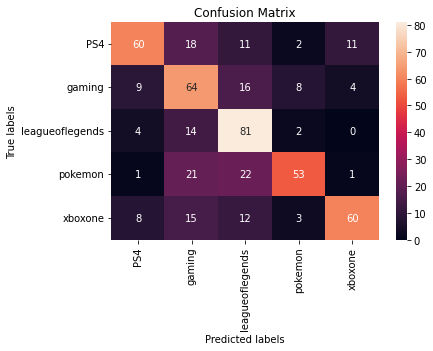

In [ ]:
# Source: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
ax= plt.subplot()
sns.heatmap(cm_t5_deslang_1000, annot=True, fmt='g', ax=ax) #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
# Source: https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.xaxis.set_ticklabels(['PS4', 'gaming', 'leagueoflegends', 'pokemon', 'xboxone'])
ax.yaxis.set_ticklabels(['PS4', 'gaming', 'leagueoflegends', 'pokemon', 'xboxone'])

In [ ]:
#analyze wrong examples in most wrong class
df_similar_sub_1000_test_prep_deslang['preds'] = preds_similar_deslang_1000
df_similar_sub_1000_test_prep_deslang['preds'].value_counts()

#df_similar_sub_1000_test_prep_deslang_filt = df_similar_sub_1000_test_prep_deslang.loc[(df_similar_sub_1000_test_prep_deslang['preds'] == 'leagueoflegends') & (df_similar_sub_1000_test_prep_deslang['target_text'] == 'pokemon')]

leagueoflegends    142
gaming             132
PS4                 82
xboxone             76
pokemon             68
Name: preds, dtype: int64

In [ ]:
df_similar_sub_1000_test_prep_deslang_filt = df_similar_sub_1000_test_prep_deslang.loc[(df_similar_sub_1000_test_prep_deslang['target_text'] == 'pokemon') & (df_similar_sub_1000_test_prep_deslang['preds'] == 'leagueoflegends')]
#df_similar_sub_1000_test_prep_deslang_filt = df_similar_sub_1000_test_prep_deslang.loc[(df_similar_sub_1000_test_prep_deslang['target_text'] == 'pokemon') & (df_similar_sub_1000_test_prep_deslang['preds'] == 'leagueoflegends')]

In [ ]:
#examples:
#cleaning services, maids nyc
#well i can't deal with it snapchat, well i can't deal with it
#what i first thought of when the title dropped.

In [ ]:
len(df_similar_sub_1000_test_prep_deslang_filt)

22

In [ ]:
df_similar_sub_1000_test_prep_deslang_filt['input_text']

2101                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [removed]
2123                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
df_similar_sub_1000_test_prep_deslang_filt2 = df_similar_sub_1000_test_prep_deslang.loc[(df_similar_sub_1000_test_prep_deslang['target_text'] == 'leagueoflegends') & (df_similar_sub_1000_test_prep_deslang['preds'] == 'leagueoflegends')]

In [ ]:
df_similar_sub_1000_test_prep_deslang_filt2['input_text']

4000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        i will just climb back but since the abundance of ''is the best feeling in league, is the worst feeling in league'' posts i thought i'd post the true holy grail of what feelings bad truly is.\n\nhypertext transfer protocol secure://i.redd.it/uca2fnpmin